# Data preprocessing with ONNX: ResNet-50 example

In this example we will show how to integrate an existing ResNet model for image classification with a data preprocessing pipeline written in ONNX. We will show how to create a combined model including data preprocessing.

First, let us import the packages we need, and load images that we will use in the example.

In [1]:
import numpy as np  # type: ignore
import onnx
from onnx import parser
from onnx import checker
from onnx import helper
from onnx import TensorProto as tp
from onnx import save
import onnxruntime

import os
os.environ["ALLOW_RELEASED_ONNX_OPSET_ONLY"] = "0"

Output sizes: 
(400, 266)
(348, 348)


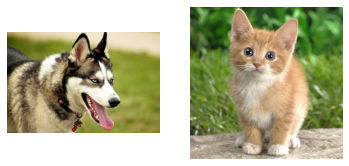

In [2]:
# display images in the notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

def show_images(images):
    nsamples = len(images)
    print("Output sizes: ")
    for i in range(nsamples):
        print(images[i].size)
    fig, axs = plt.subplots(1, nsamples)
    for i in range(nsamples):
        axs[i].axis('off')
        axs[i].imshow(images[i])
    plt.show()

images = [
    Image.open('assets/dog.jpg'),
    Image.open('assets/cat.jpg')
]
show_images(images)

## Using an existing model

For this example, we will use an existing ResNet50 model from the ONNX model repository 

In [3]:
!wget https://raw.githubusercontent.com/onnx/models/main/vision/classification/resnet/model/resnet50-v1-12.onnx

--2022-04-08 13:13:29--  https://raw.githubusercontent.com/onnx/models/main/vision/classification/resnet/model/resnet50-v1-12.onnx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102576417 (98M) [application/octet-stream]
Saving to: ‘resnet50-v1-12.onnx’

resnet50-v1-12.onnx 100%[===================>]  97.82M  47.9MB/s    in 2.0s    

2022-04-08 13:13:31 (47.9 MB/s) - ‘resnet50-v1-12.onnx’ saved [102576417/102576417]



Let us load and inspect the model to see what inputs/outputs it expects

In [4]:
rn50_network = onnx.load('./resnet50-v1-12.onnx')
print("Inputs: ", rn50_network.graph.input)
print("Outputs: ", rn50_network.graph.output)

Inputs:  [name: "data"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 224
      }
      dim {
        dim_value: 224
      }
    }
  }
}
]
Outputs:  [name: "resnetv17_dense0_fwd"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 1000
      }
    }
  }
}
]


## Defining the preprocessing model

Let us define now the data preprocessing pipeline to be applied to the images before feeding them to the network. The preprocessing pipeline consists of a resize operation, a centered crop operation, normalization and transposition. The result should be a float32 tensor with shape `[1, 3, 224, 224]`.

In general terms, we want our preprocessing model to be able to perform batch processing (several images in one go). For this, we use the SequenceMap operation to apply a sample processing graph to each image independently, then combined the processed outputs into a single tensor by concatenating all the tensors. The first dimension represents the batch dimension.

In [5]:
rn50_preprocessing_sample = parser.parse_graph('''
    rn50_preprocessing_sample (uint8[H, W, 3] image) => (float[3, 224, 224] image_processed)
    {
        target_size = Constant <value = float[2] {256.0, 256.0}> ()
        image_shape = Shape (image)
        h, w, c = Split <axis = 0> (image_shape)
        hw = Concat <axis = 0> (h, w)
        hw_f = Cast <to = 1> (hw)
        target_size_f = Cast <to = 1> (target_size)
        ratios = Div(target_size_f, hw_f)
        ratio_resize = ReduceMax(ratios)

        k1f = Constant <value = float[1] {1.0}> ()
        scales_resize = Concat <axis = 0> (ratio_resize, ratio_resize, k1f)
        image_resized = Resize <mode = \"linear\"> (image, , scales_resize)
        
        target_crop = Constant <value = int64[2] {224, 224}> ()
        k2 = Constant <value = int64[1] {2}> ()
        axes = Constant <value = int64[2] {0, 1}> ()
        x_shape2 = Shape (image_resized)
        h2, w2, c2 = Split <axis = 0> (x_shape2)
        hw2 = Concat <axis = 0> (h2, w2)
        hw_diff = Sub (hw2, target_crop)
        start_xy = Div (hw_diff, k2)
        end_xy = Add (start_xy, target_crop)
        image_sliced = Slice (image_resized, start_xy, end_xy, axes)
        
        kMean = Constant <value = float[3] {123.675, 116.28, 103.53}> ()
        kStddev = Constant <value = float[3] {58.395, 57.12, 57.375}> ()
        im_norm_tmp1 = Cast <to = 1> (image_sliced)
        im_norm_tmp2 = Sub (im_norm_tmp1, kMean)
        im_norm = Div (im_norm_tmp2, kStddev)
        
        image_processed = Transpose <perm = [2, 0, 1]> (im_norm)
    }
    ''')

op = onnx.OperatorSetIdProto()
op.version = 16

rn50_preprocessing_model = helper.make_model(
    onnx.helper.make_graph(
        nodes=[
            onnx.helper.make_node('SequenceMap', body=rn50_preprocessing_sample, inputs=['preprocessing_input'], 
                                  outputs=['preprocessed_batch']),
            onnx.helper.make_node('ConcatFromSequence', axis=0, new_axis=1, inputs=['preprocessed_batch'], 
                                  outputs=['preprocessing_output']),
        ],
        name='rn50_preprocessing_batch',
        inputs=[onnx.helper.make_tensor_sequence_value_info('preprocessing_input', onnx.TensorProto.UINT8, 
                                                            ['H', 'W', 3])],
        outputs=[onnx.helper.make_tensor_value_info('preprocessing_output', onnx.TensorProto.FLOAT, 
                                                    ['N', 3, 224, 224])],
    ),
    producer_name='test', opset_imports=[op])
checker.check_model(rn50_preprocessing_model)
onnx.save(rn50_preprocessing_model, 'rn50_preprocessing.onnx')

We can now test the preprocessing model we created with ONNX runtime. We can process a single image by passing an array with a single numpy array (please note that the model takes a sequence of inputs). 

In [6]:
session = onnxruntime.InferenceSession('rn50_preprocessing.onnx', None)
data = session.run([], {'preprocessing_input': [np.array(images[0])]})[0]
print(f"Preprocessed data: type={data.dtype} shape={data.shape}")

Preprocessed data: type=float32 shape=(1, 3, 224, 224)


2022-04-08 12:13:31.874193822 [W:onnxruntime:, constant_folding.cc:202 ApplyImpl] Unsupported output type of N11onnxruntime22SequenceTensorTypeBaseE. Can't constant fold SequenceEmpty node '0x40ca7a00x3dcb740'
2022-04-08 12:13:31.874438835 [W:onnxruntime:, constant_folding.cc:202 ApplyImpl] Unsupported output type of N11onnxruntime22SequenceTensorTypeBaseE. Can't constant fold SequenceEmpty node '0x40ca7a00x3dcb740'


Thanks to the batch processing capabilities of the model, we can also run it with several images at once.

In [7]:
data = session.run([], {'preprocessing_input': [np.array(image) for image in images]})[0]
print(f"Preprocessed data: type={data.dtype} shape={data.shape}")

Preprocessed data: type=float32 shape=(2, 3, 224, 224)


As an exercise, and for the sake of visualization, we can visualize the preprocessing output by restoring the original channel-last layout and concatenating the data from the two images side by side.

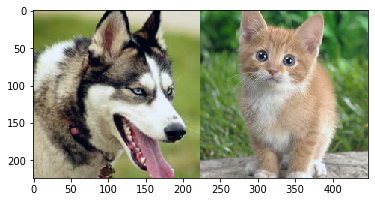

In [8]:
def visualize_processed_batch(data):
    samples = []
    for i in range(data.shape[0]):
        samples.append(np.transpose(data[i], axes=[1, 2, 0]))
    data_plot = np.concatenate(samples, axis=1)

    def scale(A):
        return (A-np.min(A))/(np.max(A) - np.min(A))
    data_plot = scale(data_plot)
    plt.imshow(data_plot, interpolation='nearest')    

visualize_processed_batch(data)

## Combining the models: Preprocessing + network

We can produce a combined model performing both the preprocessing and the network inference step. For this, we can use ONNX compose utils. We can connect the output of the preprocessing model to the input of the network.

To be able to combine the models, they need to share the same IR version and Operator set versions. We can achieve that by converting the network model to the higher operator set version.

In [9]:
from onnx import version_converter
rn50_network = onnx.version_converter.convert_version(rn50_network, 16)
rn50_network.ir_version = 8  # Not sure if that's OK, but it seems to work
checker.check_model(rn50_network)

In [10]:
rn50_combined = onnx.compose.merge_models(
    rn50_preprocessing_model, rn50_network,
    io_map=[('preprocessing_output', 'data')]
)
checker.check_model(rn50_combined)
print("Input: ", rn50_combined.graph.input)
print("Output: ", rn50_combined.graph.output)
onnx.save(rn50_combined, 'rn50_combined.onnx')

Input:  [name: "preprocessing_input"
type {
  sequence_type {
    elem_type {
      tensor_type {
        elem_type: 2
        shape {
          dim {
            dim_param: "H"
          }
          dim {
            dim_param: "W"
          }
          dim {
            dim_value: 3
          }
        }
      }
    }
  }
}
]
Output:  [name: "resnetv17_dense0_fwd"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 1000
      }
    }
  }
}
]


Now we are ready to run the combined model.

In [11]:
session = onnxruntime.InferenceSession('rn50_combined.onnx', None)
result = session.run([], {'preprocessing_input': [np.array(image) for image in images]})[0]
print(f"Preprocessed data: type={result.dtype} shape={result.shape}")

Preprocessed data: type=float32 shape=(2, 1000)


2022-04-08 12:13:34.716870653 [W:onnxruntime:, constant_folding.cc:202 ApplyImpl] Unsupported output type of N11onnxruntime22SequenceTensorTypeBaseE. Can't constant fold SequenceEmpty node '0x157d56c00xa90d300'
2022-04-08 12:13:34.717639052 [W:onnxruntime:, constant_folding.cc:202 ApplyImpl] Unsupported output type of N11onnxruntime22SequenceTensorTypeBaseE. Can't constant fold SequenceEmpty node '0x157d56c00xa90d300'
2022-04-08 12:13:34.971220313 [W:onnxruntime:, execution_frame.cc:806 VerifyOutputSizes] Expected shape from model of {1,1000} does not match actual shape of {2,1000} for output resnetv17_dense0_fwd


Finally, let us define some utility functions to verify the predictions from the network make sense.

In [12]:
import urllib.request
import json

def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)

imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
urllib.request.urlretrieve(imagenet_labels_url, filename="imagenet-simple-labels.json")
labels = load_labels('imagenet-simple-labels.json')

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

def predict(image, raw_result):
    res = postprocess(raw_result)    

    idx = np.argmax(res)

    print('========================================')
    print('Final top prediction is: ' + labels[idx])
    print('========================================')

    sort_idx = np.flip(np.squeeze(np.argsort(res)))
    print('============ Top 5 labels are: ============================')
    print(labels[sort_idx[:5]])
    print('===========================================================')

    plt.axis('off')
    display_image = plt.imshow(image)

In [13]:
raw_result = session.run([], {'preprocessing_input': [np.array(image) for image in images]})[0]
print(f"Raw result: dtype={raw_result.dtype} shape={raw_result.shape}")

Raw result: dtype=float32 shape=(2, 1000)


2022-04-08 12:13:35.289633299 [W:onnxruntime:, execution_frame.cc:806 VerifyOutputSizes] Expected shape from model of {1,1000} does not match actual shape of {2,1000} for output resnetv17_dense0_fwd


Final top prediction is: husky
============ Top 5 labels are: ============================
['husky' 'Siberian Husky' 'Alaskan Malamute' 'Norwegian Elkhound'
 'grey wolf']


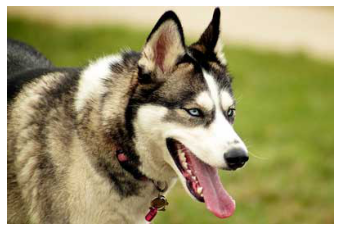

In [14]:
predict(images[0], raw_result[0])

Final top prediction is: kit fox
============ Top 5 labels are: ============================
['kit fox' 'tiger cat' 'tabby cat' 'lynx' 'red fox']


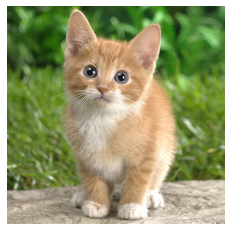

In [15]:
predict(images[1], raw_result[1])